 ## 1.0 The Bootstrap
 
 In this lab, we analyze the Pennsylvania re-employment bonus experiment, which was previously studied in "Sequential testing of duration data: the case of the Pennsylvania ‘reemployment bonus’ experiment" (Bilias, 2000), among others. These experiments were conducted in the 1980s by the U.S. Department of Labor to test the incentive effects of alternative compensation schemes for unemployment insurance (UI). In these experiments, UI claimants were randomly assigned either to a control group or one of five treatment groups. Actually, there are six treatment groups in the experiments. Here we focus on treatment group 4, but feel free to explore other treatment groups. In the control group the current rules of the UI applied. Individuals in the treatment groups were offered a cash bonus if they found a job within some pre-specified period of time (qualification period), provided that the job was retained for a specified duration. The treatments differed in the level of the bonus, the length of the qualification period, and whether the bonus was declining over time in the qualification period; see http://qed.econ.queensu.ca/jae/2000-v15.6/bilias/readme.b.txt for further details on data.

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import numpy as np

In [22]:
Penn = pd.read_csv("../../../data/penn_jae.dat" , sep='\s', engine='python')

n = Penn.shape[0]
p_1 = Penn.shape[1]

Penn = Penn[ (Penn['tg'] == 4) | (Penn['tg'] == 0) ]

In [23]:
# Dependent variable
Penn['T4'] = (Penn[['tg']]==4).astype(int)

# Create category variable
Penn['dep'] = Penn['dep'].astype( 'category' )
Penn.head()

# log - putcome variable 
Penn["log_inuidur1"] = np.log( Penn["inuidur1"] ) 

In [25]:
# equivalent to sample function in lab
def get_indices(data,num_samples):
    return  np.random.choice(data.index, num_samples, replace=True)

In [81]:
# T4, female and black 

def get_estimates(data,index):
    formula1 = " log_inuidur1 ~ 1+T4+female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd"
    
    model_results = smf.ols(formula1, data = data.loc[index]).fit()
    coef = model_results.params[3:6]
    return coef

In [77]:
    formula1 = " log_inuidur1 ~ 1+T4+female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd"
    
    model_results = smf.ols(formula1, data = Penn).fit()
    coef = model_results.params[3:6]

In [80]:
coef[2]

-0.3079053087767055

In [85]:
#modifying the boot mentioned that we used earlier
def boot(data,func,R):
    coeff1 = []
    coeff2 = []
    coeff3 = []
    for i in range(R):
        coeff1.append(func(data,get_indices(data,n))[0]) 
        coeff2.append(func(data,get_indices(data,n))[1])
        coeff3.append(func(data,get_indices(data,n))[2])

    coeff1_statistices = {'Estimate':np.mean(coeff1),'Standar error':np.std(coeff1)}  
    coeff2_statistices = {'Estimate':np.mean(coeff2),'Standar error':np.std(coeff2)} 
    coeff3_statistices = {'Estimate':np.mean(coeff3),'Standar error':np.std(coeff3)} 
    return {'T4':coeff1_statistices,
            'Females':coeff2_statistices,'Black':coeff3_statistices}

In [87]:
results = boot(Penn,get_estimates,1000)

print('Result for coefficient term T4',results['T4'])
print('Result for coefficient term female',results['Females'])
print('Result for coefficient term black',results['Black'])

Result for coefficient term T4 {'Estimate': -0.07591474618268888, 'Standar error': 0.02133364485297246}
Result for coefficient term female {'Estimate': 0.13675115446098726, 'Standar error': 0.020641534891696806}
Result for coefficient term black {'Estimate': -0.30829835375312836, 'Standar error': 0.037403692175662646}


In [88]:
pd.DataFrame(results)

,T4,Females,Black
Estimate,-0.075915,0.136751,-0.308298
Standar error,0.021334,0.020642,0.037404


## Comparative Models 

In [106]:
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random

In [107]:
cps2012_env = pyreadr.read_r("../../../data/cps2012.Rdata")
cps2012 = cps2012_env[ 'data' ]

In [108]:
nrow = cps2012.shape[0]
length = int(nrow*(3/4))

In [109]:
from numpy.random import default_rng

random.seed(30)

rng = default_rng()

training = rng.choice(nrow, size = length, replace=False)

training_bool = cps2012.index.isin( training )

data_train = cps2012.iloc[training,:]

data_train = cps2012[training_bool]
data_test = cps2012[~training_bool]

In [110]:
# Basic model 

formula_basic =  '''lnw ~ female + female:(widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3)  '''

formula_flex =  '''lnw ~ female + female:(widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3) +(widowed +
divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
we + exp1 + exp2 + exp3) ** 2'''

y_basic_train, model_X_basic_train = patsy.dmatrices(formula_basic, data_train, return_type='dataframe')
y_basic_test, model_X_basic_test = patsy.dmatrices(formula_basic, data_test, return_type='dataframe')
p_basic = model_X_basic_train.shape[ 1 ]

y_flex_train, model_X_flex_train = patsy.dmatrices(formula_flex, data_train, return_type='dataframe')
y_flex_test, model_X_flex_test = patsy.dmatrices(formula_flex, data_test, return_type='dataframe')
p_flex = model_X_flex_train.shape[ 1 ]

Y_train = data_train['lnw']
Y_test = data_test['lnw']

# step 2, drop constant variance variable

variance_cols = model_X_basic_train.var().to_numpy() 
model_X_basic_train = model_X_basic_train.iloc[ : ,  np.where( variance_cols != 0   )[0] ]

variance_cols = model_X_basic_test.var().to_numpy() 
model_X_basic_test = model_X_basic_test.iloc[ : ,  np.where( variance_cols != 0   )[0] ]


variance_cols = model_X_flex_train.var().to_numpy() 
model_X_flex_train = model_X_flex_train.iloc[ : ,  np.where( variance_cols != 0   )[0] ]

variance_cols = model_X_flex_test.var().to_numpy() 
model_X_flex_test = model_X_flex_test.iloc[ : ,  np.where( variance_cols != 0   )[0] ]

### OLS

In [111]:
# ols (basic model)
model_X_basic_train = sm.add_constant(model_X_basic_train)
model_X_basic_test = sm.add_constant(model_X_basic_test)

lm_basic = sm.OLS( Y_train, model_X_basic_train )
fit_lm_basic = lm_basic.fit()

# Compute the Out-Of-Sample Performance
yhat_lm_basic = fit_lm_basic.predict( model_X_basic_test )

resid_basic = (Y_test-yhat_lm_basic)**2

# Compute MSE and R square 
MSE_lm_basic = sm.OLS( resid_basic , np.ones( resid_basic.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
R2_lm_basic = 1 - ( MSE_lm_basic[0]/Y_test.var() )

In [112]:
# ols (flex model)
model_X_flex_train = sm.add_constant(model_X_flex_train)
model_X_flex_test = sm.add_constant(model_X_flex_test)

lm_flex = sm.OLS( Y_train, model_X_flex_train )
fit_lm_flex = lm_flex.fit()

yhat_lm_flex = fit_lm_flex.predict( model_X_flex_test )

resid_flex = (Y_test-yhat_lm_flex)**2

MSE_lm_flex = sm.OLS( resid_flex , np.ones( resid_flex.shape[0] ) ).fit().summary2().tables[1].iloc[0, 0:2]
MSE_lm_flex

R2_lm_flex = 1 - ( MSE_lm_flex[0]/Y_test.var() )

### Lasso, Ridge and Elastic Net

In [113]:
import hdmpy

In [114]:
fit_rlasso = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post = hdmpy.rlasso( model_X_basic_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\l

#### Estimating the predictions from rlasso models
We have to know that the residuals output come from this formula:

- x1 = x - np.ones( (x.shape[1] , 1) ) @ x.mean( axis = 0 )
- beta = model.est['beta'].loc[ fit_rlasso.est['index'].iloc[:, 0].to_list(), ].to_numpy()
- y1 = y - y.mean()
- yhat = x1 @ beta + y.mean()

So we have to apply those transfomations to original test data


In [115]:
# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)


# Getting the significant variables
x1_est_rlasso = new_x1[ :, fit_rlasso.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso = fit_rlasso.est['beta'].loc[ fit_rlasso.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()



# yhat
yhat_rlasso = (x1_est_rlasso @ beta_rlasso) + np.mean( Y_test.to_numpy() )
residuals_rlasso = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso

In [116]:
# Post Lasso

# Getting mean of each variable
meanx = model_X_basic_test.mean( axis = 0 ).values.\
                        reshape( model_X_basic_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_basic_test.to_numpy() - \
                    (np.ones( ( model_X_basic_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post = new_x1[ :, fit_rlasso_post.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post = fit_rlasso_post.est['beta'].loc[ fit_rlasso_post.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post = (x1_est_rlasso_post @ beta_rlasso_post) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post

In [117]:
MSE_lasso = sm.OLS( ( residuals_rlasso )**2 , np.ones( yhat_rlasso.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post = sm.OLS( ( residuals_rlasso_post )**2  , np.ones( yhat_rlasso_post.size )  ).fit().summary2().tables[1].round(3)

R2_lasso = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post = 1 - MSE_lasso_post.iloc[0, 0]/ np.var( Y_test )

print( f"The R^2 using the basic model is equal to {R2_lasso},for lasso and {R2_lasso_post} for post-lasso") # R^2 lasso/post-lasso (basic model) 

The R^2 using the basic model is equal to 0.11854767892550122,for lasso and 0.11854767892550122 for post-lasso


Now, we repeat the same procedure for the flexible model.

In [118]:
fit_rlasso_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = False )
fit_rlasso_post_flex = hdmpy.rlasso( model_X_flex_train.to_numpy() , Y_train.to_numpy().reshape( Y_train.size , 1 ) , post = True )

C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Roberto\anaconda3\lib\site-packages\numpy\l

In [119]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_flex = new_x1[ :, fit_rlasso_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_flex = fit_rlasso_flex.est['beta'].loc[ fit_rlasso_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_flex = (x1_est_rlasso_flex @ beta_rlasso_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_flex

In [120]:
# Getting mean of each variable
meanx = model_X_flex_test.mean( axis = 0 ).values.\
                        reshape( model_X_flex_test.shape[ 1 ] , 1 )

# Reducing the mean
new_x1 = model_X_flex_test.to_numpy() - \
                    (np.ones( ( model_X_flex_test.shape[ 0 ] , 1 ) ) @ meanx.T)

# Getting the significant variables
x1_est_rlasso_post_flex = new_x1[ :, fit_rlasso_post_flex.est['index'].iloc[:, 0].to_list()]

# Getting the coef. from significant variables
beta_rlasso_post_flex = fit_rlasso_post_flex.est['beta'].loc[ fit_rlasso_post_flex.est['index'].\
                                     iloc[:, 0].to_list(), ].to_numpy()

# yhat
yhat_rlasso_post_flex = (x1_est_rlasso_post_flex @ beta_rlasso_post_flex) + np.mean( Y_test.to_numpy() )
residuals_rlasso_post_flex = Y_test.to_numpy().reshape( Y_test.to_numpy().size, 1)  - yhat_rlasso_post_flex

In [121]:
MSE_lasso_flex = sm.OLS( ( residuals_rlasso_flex )**2 , np.ones( yhat_rlasso_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_lasso_post_flex = sm.OLS( ( residuals_rlasso_post_flex )**2  , np.ones( yhat_rlasso_post_flex.size )  ).fit().summary2().tables[1].round(3)

R2_lasso_flex = 1 - MSE_lasso.iloc[0, 0]/ np.var( Y_test )
R2_lasso_post_flex = 1 - MSE_lasso_post_flex.iloc[0, 0]/ np.var( Y_test )
 

It is worth to notice that lasso regression works better for the more complex model.

In contrast to a theoretical based choice of the tuning parameter $\lambda$ in the lasso regression, we can also use cross-validation to determine the penalty level by applying the package *glmnet* and the function cv.glmnet. In this context, we also run a ridge and a elastic net regression by adjusting the parameter *alpha*.

In [122]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, ElasticNetCV
import statsmodels.api as sm

In [123]:
Y_vec = Y_train.to_numpy().reshape( Y_train.to_numpy().size, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )

std_Y = scaler.transform( Y_vec )

std_Y 

array([[-1.34502346],
       [-2.16572393],
       [-0.3931503 ],
       ...,
       [-0.11333549],
       [ 0.51549868],
       [-0.55405417]])

In [124]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape(-1, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )  # mean and standar deviation
std_Y = scaler.transform( Y_vec )  # scale 

# Regressions
fit_lasso_cv_basic = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_basic_train, std_Y )

fit_ridge_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_basic_train , std_Y )
fit_elnet_basic = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_basic_train , std_Y )



# Predictions

yhat_lasso_cv_basic = scaler.inverse_transform( fit_lasso_cv_basic.predict( model_X_basic_test ).reshape(-1, 1) )
yhat_ridge_basic = scaler.inverse_transform( fit_ridge_basic.predict( model_X_basic_test ).reshape(-1, 1) )
yhat_elnet_basic = scaler.inverse_transform( fit_elnet_basic.predict( model_X_basic_test ).reshape(-1, 1) )

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0905710048245965, tolerance: 1.9717050221467523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.775516529054585, tolerance: 1.9717050221467523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Convergence

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.275e+01, tolerance: 2.191e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(St

In [125]:
MSE_lasso_cv_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_basic)**2 ) , np.ones( yhat_lasso_cv_basic.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_basic)**2 ) , np.ones( yhat_ridge_basic.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_basic = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_basic)**2 ) , np.ones( yhat_elnet_basic.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [126]:
R2_lasso_cv_basic = 1- MSE_ridge_basic.iloc[0,0] / np.var( Y_test )
R2_ridge_basic = 1- MSE_lasso_cv_basic.iloc[0,0] / np.var( Y_test )
R2_elnet_basic = 1- MSE_elnet_basic.iloc[0,0] / np.var( Y_test )

In [127]:
# Reshaping Y variable
Y_vec = Y_train.to_numpy().reshape( -1, 1)

# Scalar distribution
scaler = StandardScaler()
scaler.fit( Y_vec )
std_Y = scaler.transform( Y_vec )

# Regressions
fit_lasso_cv_flex = LassoCV(cv = 10 , random_state = 0 , normalize = True ).fit( model_X_flex_train, std_Y )
fit_ridge_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.0001 ).fit( model_X_flex_train , std_Y )
fit_elnet_flex = ElasticNetCV( cv = 10 , normalize = True , random_state = 0 , l1_ratio = 0.5, max_iter = 100000 ).fit( model_X_flex_train , std_Y )

# Predictions
yhat_lasso_cv_flex = scaler.inverse_transform( fit_lasso_cv_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_ridge_flex = scaler.inverse_transform( fit_ridge_flex.predict( model_X_flex_test ).reshape(-1,1) )
yhat_elnet_flex = scaler.inverse_transform( fit_elnet_flex.predict( model_X_flex_test ).reshape(-1,1) )

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.035704891917703, tolerance: 1.9717050221467523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.703104430100211, tolerance: 1.9717050221467523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceW

C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8863339080162405, tolerance: 1.9881911617039523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.965663922550448, tolerance: 1.9881911617039523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6519159784002113, tolerance: 1.9881911617039523
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Roberto\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desce

In [128]:
MSE_lasso_cv_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_lasso_cv_flex)**2 ) , np.ones( yhat_lasso_cv_flex.shape )  ).fit().summary2().tables[1].round(3)
MSE_ridge_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_ridge_flex)**2 ) , np.ones( yhat_ridge_flex.size )  ).fit().summary2().tables[1].round(3)
MSE_elnet_flex = sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - yhat_elnet_flex)**2 ) , np.ones( yhat_elnet_flex.size )  ).fit().summary2().tables[1].round(3)
# our coefficient of MSE_elnet are far from r output

In [129]:
R2_lasso_cv_flex = 1- MSE_ridge_flex.iloc[0,0] / np.var( Y_test )
R2_ridge_flex = 1- MSE_lasso_cv_flex.iloc[0,0] / np.var( Y_test )
R2_elnet_flex = 1- MSE_elnet_flex.iloc[0,0] / np.var( Y_test )

## Non-linear models

Besides linear regression models, we consider nonlinear regression models to build a predictive model. We are applying regression trees, random forests, boosted trees and neural nets to estimate the regression function $g(X)$. First, we load the relevant libraries

and we illustrate the application of regression trees.

### Regression Trees

We fit a regression tree to the training data using the basic model. The variable *cp* controls the complexity of the regression tree, i.e. how deep we build the tree.

In [130]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from scipy.sparse import diags
from IPython.display import Image, display
from sklearn.model_selection import cross_val_score

**cp** = It is the amout by which splitting that node would decarease the relative error.\
It has the same meaning as min_impurity_decrease 
Apparently, Sklearn does not have tree prune function as stated in theis user guide. I take the info from [this link](https://stats.stackexchange.com/questions/152553/what-is-the-equivalent-of-the-complexity-parameter-rpart-in-r-in-python-for)

we can Preprune and postprune decission trees.

Preprunning is stopping the growth of decision tree on an early stage. we can limit paramters like max_depth, min_samples. We can grid search those parameters and choose the optimum values that gives better performance on test data. 

Cost complexity pruning\
It is all about finding the right parameter for alpha. We will get the alpha values for this tree

we are going to cut some threes in order to not overfitting data. We will calculate the total sum of squared residuals from each leaf of each type of three and store that results.

how to compare these threes?

Tree Scores = SSR + alpha(Number of leafs) We will penalize for each additional three.
We will get the alpha value from cross validation. We can check the code [here](https://www.kaggle.com/arunmohan003/pruning-decision-trees).

cp = It is the minimum value that the R-squared should decrease in order to make the next splitting \
Xerror = Cross-Validated Error Rate 

## cost_complexity_pruning_path:

DecisionTree in sklearn has a function called cost_complexity_pruning_path, which gives the effective alphas of subtrees during pruning and also the corresponding impurities. In other words, we can use these values of alpha to prune our decision tree-

In [131]:
trees = DecisionTreeRegressor( random_state = 0, min_impurity_decrease = 0.001 )

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [132]:
path = trees.cost_complexity_pruning_path( model_X_basic_train, y_basic_train )

alphas, impurities = path.ccp_alphas, path.impurities

In [133]:
alphas

array([0.        , 0.00130609, 0.00138138, 0.00771384, 0.00775005,
       0.02109483])

In [134]:
mean1, std1 = [], []

for i in alphas:
     tree_initial = DecisionTreeRegressor(ccp_alpha=i, random_state=0)
# 10 fold cross validation for each alpha value
     scores = cross_val_score(tree_initial, model_X_basic_train, y_basic_train, scoring='neg_mean_squared_error', cv=10)
     mean1.append(scores.mean()), std1.append(scores.std())
            
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies

table = pd.DataFrame({"alpha": alphas, "mean": mean1, "std": std1})
table["mean"] = (-1)*table["mean"]
table = table.sort_values(["mean"], ascending = True)
table.head(10)


,alpha,mean,std
1,0.001306,0.394845,0.041061
2,0.001381,0.395935,0.041274
3,0.007714,0.409964,0.046103
4,0.007750,0.409964,0.046103
5,0.021095,0.431698,0.043923
0,0.000000,0.435915,0.046736


In [135]:
prune_tree =  DecisionTreeRegressor(ccp_alpha=table.iloc[1,0], random_state=0)

prune_tree_fit = prune_tree.fit(model_X_basic_train, y_basic_train)

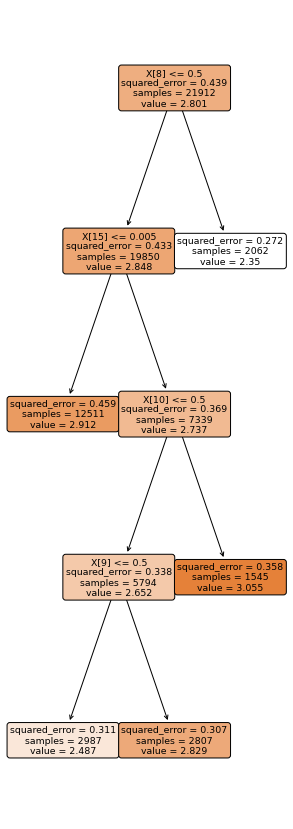

In [136]:
fig = plt.figure(figsize=(5,15))
_ = tree.plot_tree( prune_tree_fit , filled = True , rounded = True  )

In [137]:
y_hat_pt = prune_tree_fit.predict(model_X_basic_test)

MSE_pt= sm.OLS( ((Y_test.to_numpy().reshape(-1,1) - y_hat_pt.reshape(-1,1))**2 ) , np.ones( y_hat_pt.shape )  ).fit().summary2().tables[1].round(3)
R2_pt = 1- MSE_pt.iloc[0,0] / np.var( Y_test )

## Results

In [138]:
table= np.zeros( (13, 3) )
table[0,0:2]   = MSE_lm_basic
table[1,0:2]   = MSE_lm_flex
table[2,0:2]   = MSE_lasso.iloc[0, [0, 1]]
table[3,0:2]   = MSE_lasso_post.iloc[0, [0, 1]]
table[4,0:2]   = MSE_lasso_flex.iloc[0, [0, 1]]
table[5,0:2]   = MSE_lasso_post_flex.iloc[0, [0, 1]]
table[6,0:2]   = MSE_lasso_cv_basic.iloc[0, [0, 1]]
table[7,0:2]   = MSE_ridge_basic.iloc[0, [0, 1]]
table[8,0:2]   = MSE_elnet_basic.iloc[0, [0, 1]]
table[9,0:2]   = MSE_lasso_cv_flex.iloc[0, [0, 1]]
table[10,0:2]  = MSE_ridge_flex.iloc[0, [0, 1]]
table[11,0:2]  = MSE_elnet_flex.iloc[0, [0, 1]]
table[12,0:2]  = MSE_pt.iloc[0, [0, 1]]



table[0,2]   = R2_lm_basic
table[1,2]   = R2_lm_flex
table[2,2]   = R2_lasso
table[3,2]   = R2_lasso_post
table[4,2]   = R2_lasso_flex
table[5,2]   = R2_lasso_post_flex
table[6,2]   = R2_lasso_cv_basic
table[7,2]   = R2_ridge_basic
table[8,2]   = R2_elnet_basic
table[9,2]   = R2_lasso_cv_flex
table[10,2]  = R2_ridge_flex
table[11,2]  = R2_elnet_flex
table[12,2]  = R2_pt




colnames_table= ["MSE", "S_E_ for MSE", "R-squared"]
rownames_table= ["Least Squares (basic)","Least Squares (flexible)", "Lasso", "Post-Lasso","Lasso (flexible)","Post-Lasso (flexible)", \
                    "Cross-Validated lasso", "Cross-Validated ridge","Cross-Validated elnet","Cross-Validated lasso (flexible)","Cross-Validated ridge (flexible)","Cross-Validated elnet (flexible)",  \
                   "Pruned Tree"]
table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round(3)
table_html = table_pandas.to_latex()
table_pandas

C:\Users\Roberto\AppData\Local\Temp\ipykernel_10964\1735838183.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_html = table_pandas.to_latex()


,MSE,S_E_ for MSE,R-squared
Least Squares (basic),0.384,0.019,0.122
Least Squares (flexible),0.330,0.018,0.248
Lasso,0.386,0.018,0.119
Post-Lasso,0.386,0.018,0.119
Lasso (flexible),0.331,0.018,0.119
Post-Lasso (flexible),0.331,0.018,0.244
Cross-Validated lasso,0.385,0.019,-0.000
Cross-Validated ridge,0.438,0.019,0.121
Cross-Validated elnet,0.386,0.019,0.119
Cross-Validated lasso (flexible),0.329,0.018,0.004
